# How to dispatch custom callback events


In some situations, you may want to dipsatch a custom callback event from within a ```Runnable``` so it can be surfaced in a custom callback handler or via the Astream Events API.

For example, if you have a long running tool with multiple steps, you can dispatch custom events between the steps and use these custom events to monitor progress. You could also surface these custom events to an end user of your application to show them how the current task is progressing.

To dispatch a custom event you need to decide on two attributes for the event: the ```name``` and the ```data```.

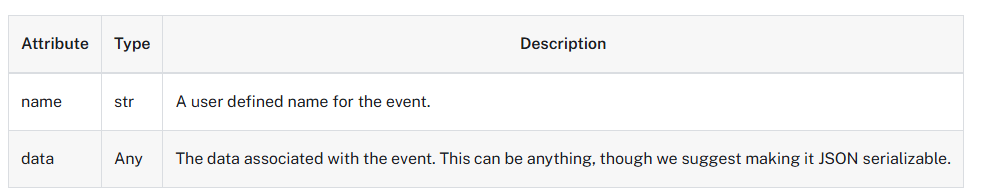

In [7]:
from langchain_core.callbacks.manager import (
    adispatch_custom_event,
)
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables.config import RunnableConfig


@RunnableLambda
async def foo(x: str, config: RunnableConfig) -> str:
    await adispatch_custom_event("event1", {"x": x}, config=config)
    await adispatch_custom_event("event2", 5, config=config)
    return x


async for event in foo.astream_events("hello world", version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': 'hello world'}, 'name': 'foo', 'tags': [], 'run_id': '7c26e434-e293-43fa-b020-65f0cf5e7127', 'metadata': {}, 'parent_ids': []}
{'event': 'on_custom_event', 'run_id': '7c26e434-e293-43fa-b020-65f0cf5e7127', 'name': 'event1', 'tags': [], 'metadata': {}, 'data': {'x': 'hello world'}, 'parent_ids': []}
{'event': 'on_custom_event', 'run_id': '7c26e434-e293-43fa-b020-65f0cf5e7127', 'name': 'event2', 'tags': [], 'metadata': {}, 'data': 5, 'parent_ids': []}
{'event': 'on_chain_stream', 'run_id': '7c26e434-e293-43fa-b020-65f0cf5e7127', 'name': 'foo', 'tags': [], 'metadata': {}, 'data': {'chunk': 'hello world'}, 'parent_ids': []}
{'event': 'on_chain_end', 'data': {'output': 'hello world'}, 'run_id': '7c26e434-e293-43fa-b020-65f0cf5e7127', 'name': 'foo', 'tags': [], 'metadata': {}, 'parent_ids': []}


In [3]:
from langchain_core.callbacks.manager import (
    adispatch_custom_event,
)
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables.config import RunnableConfig

In [4]:
@RunnableLambda
async def bar(x: str, config: RunnableConfig) -> str:
    """An example that shows how to manually propagate config.

    You must do this if you're running python<=3.10.
    """
    await adispatch_custom_event("event1", {"x": x}, config=config)
    await adispatch_custom_event("event2", 5, config=config)
    return x


async for event in bar.astream_events("hello world", version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': 'hello world'}, 'name': 'bar', 'tags': [], 'run_id': 'd743516f-488c-4ae4-9a68-89be0195bffb', 'metadata': {}, 'parent_ids': []}
{'event': 'on_custom_event', 'run_id': 'd743516f-488c-4ae4-9a68-89be0195bffb', 'name': 'event1', 'tags': [], 'metadata': {}, 'data': {'x': 'hello world'}, 'parent_ids': []}
{'event': 'on_custom_event', 'run_id': 'd743516f-488c-4ae4-9a68-89be0195bffb', 'name': 'event2', 'tags': [], 'metadata': {}, 'data': 5, 'parent_ids': []}
{'event': 'on_chain_stream', 'run_id': 'd743516f-488c-4ae4-9a68-89be0195bffb', 'name': 'bar', 'tags': [], 'metadata': {}, 'data': {'chunk': 'hello world'}, 'parent_ids': []}
{'event': 'on_chain_end', 'data': {'output': 'hello world'}, 'run_id': 'd743516f-488c-4ae4-9a68-89be0195bffb', 'name': 'bar', 'tags': [], 'metadata': {}, 'parent_ids': []}


# Async Callback Handler

You can also consume the dispatched event via an async callback handler.



In [8]:
from typing import Any, Dict, List, Optional
from uuid import UUID

from langchain_core.callbacks import AsyncCallbackHandler
from langchain_core.callbacks.manager import (
    adispatch_custom_event,
)
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables.config import RunnableConfig


class AsyncCustomCallbackHandler(AsyncCallbackHandler):
    async def on_custom_event(
        self,
        name: str,
        data: Any,
        *,
        run_id: UUID,
        tags: Optional[List[str]] = None,
        metadata: Optional[Dict[str, Any]] = None,
        **kwargs: Any,
    ) -> None:
        print(
            f"Received event {name} with data: {data}, with tags: {tags}, with metadata: {metadata} and run_id: {run_id}"
        )


@RunnableLambda
async def bar(x: str, config: RunnableConfig) -> str:
    """An example that shows how to manually propagate config.

    You must do this if you're running python<=3.10.
    """
    await adispatch_custom_event("event1", {"x": x}, config=config)
    await adispatch_custom_event("event2", 5, config=config)
    return x


async_handler = AsyncCustomCallbackHandler()
await foo.ainvoke(1, {"callbacks": [async_handler], "tags": ["foo", "bar"]})

Received event event1 with data: {'x': 1}, with tags: ['foo', 'bar'], with metadata: {} and run_id: 84d37859-10a7-4999-a9f0-ce4b616a94af
Received event event2 with data: 5, with tags: ['foo', 'bar'], with metadata: {} and run_id: 84d37859-10a7-4999-a9f0-ce4b616a94af


1

# Sync Callback Handler
Let's see how to emit custom events in a sync environment using ```dispatch_custom_event```.

You must call ```dispatch_custom_event``` from within an existing ```Runnable```.

In [9]:
from typing import Any, Dict, List, Optional
from uuid import UUID

from langchain_core.callbacks import BaseCallbackHandler
from langchain_core.callbacks.manager import (
    dispatch_custom_event,
)
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables.config import RunnableConfig


class CustomHandler(BaseCallbackHandler):
    def on_custom_event(
        self,
        name: str,
        data: Any,
        *,
        run_id: UUID,
        tags: Optional[List[str]] = None,
        metadata: Optional[Dict[str, Any]] = None,
        **kwargs: Any,
    ) -> None:
        print(
            f"Received event {name} with data: {data}, with tags: {tags}, with metadata: {metadata} and run_id: {run_id}"
        )


@RunnableLambda
def foo(x: int, config: RunnableConfig) -> int:
    dispatch_custom_event("event1", {"x": x})
    dispatch_custom_event("event2", {"x": x})
    return x


handler = CustomHandler()
foo.invoke(1, {"callbacks": [handler], "tags": ["foo", "bar"]})

Received event event1 with data: {'x': 1}, with tags: ['foo', 'bar'], with metadata: {} and run_id: 6a4ec94d-ac24-46a6-b366-9c3e76143408
Received event event2 with data: {'x': 1}, with tags: ['foo', 'bar'], with metadata: {} and run_id: 6a4ec94d-ac24-46a6-b366-9c3e76143408


1